# **Cycle node replication**

This notebook looks to replicate the Belgian "fietsknoppunten" for Gateshead, UK, based on the reserach done by Oliver Williamson (oliverwilliamson98@gmail.com).

We follow the following rules to create the network: 

1. Every village, town and major tourist attractions, where feasible, must be served.

2. National Rail stations must be served.

3. Only low traffic minor roads, bridleways, byways and existing infrastructure may be used.

4. Major roads (A and B roads) can be crossed but must not be cycled on at any point.

5. The safest route is always chosen over the shortest.

6. If a safe route cannot be provided, the destination will not be served

# Code

### Libaries

In [1]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import shapely
import pandas as pd
import numpy as np
import itertools
from shapely.geometry import LineString, GeometryCollection
from shapely.ops import unary_union
from geopy.distance import geodesic
import networkx as nx
import folium


### Set location

In [2]:
place = "Gateshead, United Kingdom"

## Download data

We get the data from OpenStreetMap in this inital test.

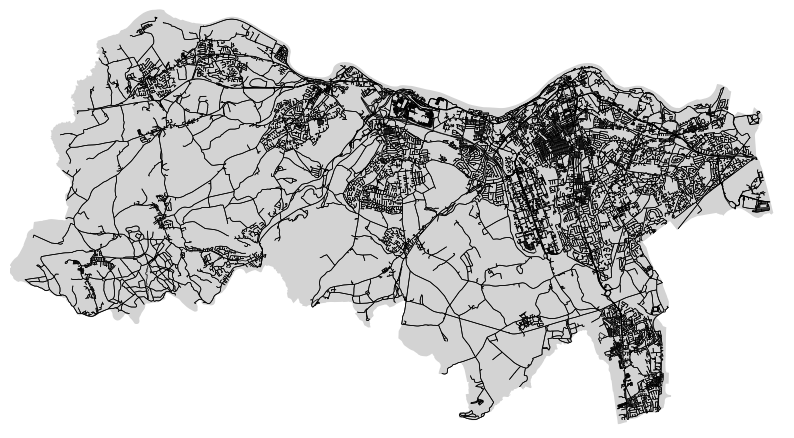

In [3]:
bike_network = ox.graph_from_place(place, network_type="bike")
boundary = ox.geocode_to_gdf(place)

fig, ax = plt.subplots(figsize=(10, 10))
# plot boundary as grey polygon
boundary.plot(ax=ax, color="lightgrey", edgecolor="none")
# overlay bike network: thin black edges, no nodes
fig, ax = ox.plot_graph(
    bike_network,
    ax=ax,
    node_size=0,
    edge_color="black",
    edge_linewidth=0.5,
    show=False,
    close=False,
)
ax.set_axis_off()
plt.show()

### Rule 1: Every village, town and major tourist attraction must be served

thoughts:
- maybe we could get the stroke value through towns to make the node more "useful"?
- user defined tourist attractions may be useful

In [4]:
town_tags = {"place": ["town", "village", "city", "hamlet", "suburb", "quarter", "neighbourhood"]}

towns = ox.features_from_polygon(boundary.iloc[0].geometry, tags=town_tags)

# convert any areas to centroids
towns = towns.copy()
towns["geometry"] = towns.geometry.apply(lambda g: g.centroid if g.geom_type in ["Polygon", "MultiPolygon"] else g)
towns = towns[towns.geometry.within(boundary.iloc[0].geometry)].copy()

# snap to bike network
bike_net_nodes = ox.graph_to_gdfs(bike_network, edges=False)


In [5]:
tourism_tags = {"tourism": ["museum", "viewpoint", "infomation", "attraction", "gallery", "zoo"]} # examples!

tourism = ox.features_from_polygon(boundary.iloc[0].geometry, tags=tourism_tags)

tourism = tourism.copy()
tourism["geometry"] = tourism.geometry.apply(lambda g: g.centroid if g.geom_type in ["Polygon", "MultiPolygon"] else g)
tourism = tourism[tourism.geometry.within(boundary.iloc[0].geometry)].copy()


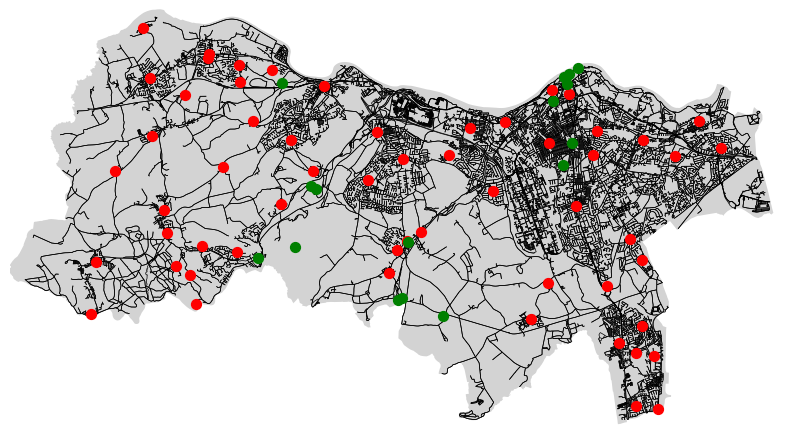

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
# plot boundary as grey polygon
boundary.plot(ax=ax, color="lightgrey", edgecolor="none")
# overlay bike network: thin black edges, no nodes
fig, ax = ox.plot_graph(
    bike_network,
    ax=ax,
    node_size=0,
    edge_color="black",
    edge_linewidth=0.5,
    show=False,
    close=False,
)
towns.plot(ax=ax, color='red', markersize=50)
tourism.plot(ax=ax, color='green', markersize=50)
ax.set_axis_off()
plt.show()

### Rule 2: National Rail stations must be served

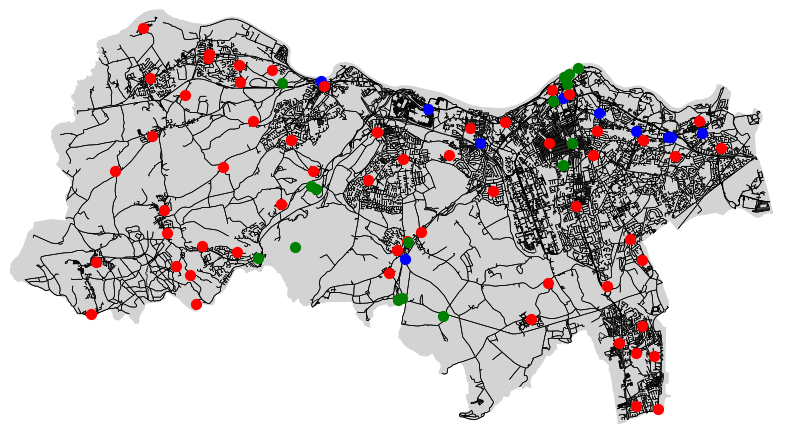

In [7]:
rail_tags = {"railway": "station"}

rail_stations = ox.features_from_polygon(boundary.geometry.iloc[0],tags=rail_tags)

fig, ax = plt.subplots(figsize=(10, 10))
# plot boundary as grey polygon
boundary.plot(ax=ax, color="lightgrey", edgecolor="none")
# overlay bike network: thin black edges, no nodes
fig, ax = ox.plot_graph(
    bike_network,
    ax=ax,
    node_size=0,
    edge_color="black",
    edge_linewidth=0.5,
    show=False,
    close=False,
)
rail_stations.plot(ax=ax, color='blue', markersize=50)
towns.plot(ax=ax, color='red', markersize=50)
tourism.plot(ax=ax, color='green', markersize=50)
ax.set_axis_off()
plt.show()

### Rule 3: Only low traffic minor roads, bridleways, byways and existing infrastructure may be used

thoughts:
- get rid of high level of traffic stress class streets using this:

      "motorway": 4,
      "motorway_link": 4,
      "trunk": 4,
      "trunk_link": 4,
      "primary": 4,
      "primary_link": 4,
      "secondary": 4,
      "secondary_link": 4,
      "tertiary": 3,
      "tertiary_link": 3,
      "unclassified": 3,
      "residential": 2,
      "living_street": 2,
      "cycleway": 1,
      "track": 1,
      "path": 1,
      "bridleway": 1

where anything greater than lts 2 is no acceptable to cycle on. might need changing r.e. unclassified for rural

In [ ]:
routeable_network = bike_network.copy()
non_routable_network = nx.MultiDiGraph()

to_drop = {
    "motorway", "motorway_link",
    "trunk", "trunk_link",
    "primary", "primary_link",
    "secondary", "secondary_link",
    # "tertiary", "tertiary_link"
}

# Split edges 
for u, v, k, data in bike_network.edges(keys=True, data=True):
    highway = data.get("highway")
    
    drop_edge = False
    if isinstance(highway, list):
        drop_edge = any(h in to_drop for h in highway)
    elif isinstance(highway, str):
        drop_edge = highway in to_drop
    
    if drop_edge:
        # Add edge and nodes to non_routable_network
        for n in [u, v]:
            if n not in non_routable_network:
                non_routable_network.add_node(n, **bike_network.nodes[n])
        non_routable_network.add_edge(u, v, key=k, **data)
        # Remove from routeable_network if it exists
        if routeable_network.has_edge(u, v, k):
            routeable_network.remove_edge(u, v, k)

# Remove isolated nodes in both graphs 
for G in [routeable_network, non_routable_network]:
    isolated = [n for n, d in G.degree() if d == 0]
    G.remove_nodes_from(isolated)

# Copy graph-level attributes (like CRS) 
non_routable_network.graph.update(bike_network.graph)


### Rule 4: Major roads (A and B roads) can be crossed but must not be cycled on at any point. 

not sure how to go about this yet?

### Rule 5: The safest route is always chosen over the shortest. 

thoughts:
- lts traffic routing :)

In [59]:
lts_lookup = {
    "motorway": 4,
    "motorway_link": 4,
    "trunk": 4,
    "trunk_link": 4,
    "primary": 4,
    "primary_link": 4,
    "secondary": 4,
    "secondary_link": 4,
    "tertiary": 3,
    "tertiary_link": 3,
    "unclassified": 3,
    "service": 2, # maybe change??
    "residential": 2,
    "living_street": 2,
    "cycleway": 1,
    "track": 1,
    "path": 1,
    "bridleway": 1}

for u, v, k, data in routeable_network.edges(keys=True, data=True):

    highway = data.get("highway")
    length = data.get("length", 0.0)

    if isinstance(highway, list):
        # take the *lowest stress* class if multiple are tagged
        lts_class = min(lts_lookup.get(h, 4) for h in highway)
    elif isinstance(highway, str):
        lts_class = lts_lookup.get(highway, 4)
    else:
        lts_class = 3  # if unknown, assume moderate stress

    data["lts_class"] = lts_class
    data["lts_distance"] = float(length) * float(lts_class)


# Create network

To connect between places, we'll use greedy triangulation to make sure all nodes are connected in all directions

In [60]:
tourism['source'] = 'Tourism'
rail_stations['source'] = 'Rail Station'
towns['source'] = 'Town'
nodes = gpd.GeoDataFrame(pd.concat([tourism, rail_stations, towns], ignore_index=True),crs=towns.crs)

In [61]:
def build_greedy_triangulation_from_nodes(nodes_gdf):
    """ 
    Perform a greedy triangulation using a generic set of point nodes
    """

    #  Copy and assign unique IDs
    nodes_gdf = nodes_gdf.copy()
    nodes_gdf["id"] = range(1, len(nodes_gdf) + 1)

    #  Ensure distances are in meters 
    nodes_gdf = nodes_gdf.to_crs("EPSG:3857")

    # Extract coordinates
    points = list(nodes_gdf.geometry)
    coords = np.array([(point.x, point.y) for point in points])

    # Compute all possible edges 
    edges = []
    for i, j in itertools.combinations(range(len(coords)), 2):
        distance = np.linalg.norm(coords[i] - coords[j])
        edges.append((i, j, distance))

    # Sort edges by distance 
    edges = sorted(edges, key=lambda x: x[2])

    # Initialize triangulation
    selected_edges = []
    existing_lines = GeometryCollection()

    # Greedy non-crossing selection 
    for i, j, distance in edges:
        new_edge = LineString([coords[i], coords[j]])
        if not existing_lines.crosses(new_edge):
            selected_edges.append((i, j, distance))
            existing_lines = unary_union([existing_lines, new_edge])

    # Convert back to lat/lon for geodesic distance 
    nodes_gdf = nodes_gdf.to_crs("EPSG:4326")

    node_distances = {}
    for (idx1, row1), (idx2, row2) in itertools.combinations(nodes_gdf.iterrows(), 2):
        coord1 = (row1.geometry.y, row1.geometry.x)
        coord2 = (row2.geometry.y, row2.geometry.x)
        distance = geodesic(coord1, coord2).meters
        node_distances[(idx1, idx2)] = distance

    # Build GeoDataFrame for triangulation edges 
    lines = []
    start_id = []
    end_id = []
    distances = []

    for i, j, _ in selected_edges:
        lines.append(LineString([coords[i], coords[j]]))

        start_id.append(nodes_gdf.iloc[i]['id'])
        end_id.append(nodes_gdf.iloc[j]['id'])

        distance = node_distances[(i, j)]
        distances.append(distance)

    greedy_triangulation_gdf = gpd.GeoDataFrame(
        {
            "geometry": lines,
            "start_id": start_id,
            "end_id": end_id,
            "distance": distances,
        },
        crs=4326,
    )

    return greedy_triangulation_gdf, nodes_gdf



greedy_edges, processed_nodes = build_greedy_triangulation_from_nodes(nodes)

### find nearest nodes

In [62]:
processed_nodes['nearest_bike_node'] = ox.distance.nearest_nodes(
    routeable_network,
    X=processed_nodes.geometry.x,
    Y=processed_nodes.geometry.y
)

In [63]:
ids = processed_nodes.set_index('id')['nearest_bike_node'].to_dict()
greedy_edges['start_node'] = greedy_edges['start_id'].map(ids)
greedy_edges['end_node']   = greedy_edges['end_id'].map(ids)

### do the routing

In [64]:
routed_edges_list = []

for _, row in greedy_edges.iterrows():
    u = row['start_node']
    v = row['end_node']
    
    try:
        path = nx.shortest_path(routeable_network, source=u, target=v, weight='lts_distance')
    except nx.NetworkXNoPath:
        continue  # skip if no path exists
    
    # Iterate over edges in this path
    for i in range(len(path)-1):
        edge_data = routeable_network.get_edge_data(path[i], path[i+1])
        # If multigraph, pick the first edge (or you could handle all keys)
        edge_data = edge_data[list(edge_data.keys())[0]] if routeable_network.is_multigraph() else edge_data
        
        routed_edges_list.append({
            'u': path[i],
            'v': path[i+1],
            'geometry': edge_data.get('geometry', LineString([
                (routeable_network.nodes[path[i]]['x'], routeable_network.nodes[path[i]]['y']),
                (routeable_network.nodes[path[i+1]]['x'], routeable_network.nodes[path[i+1]]['y'])
            ])),
            'lts_distance': edge_data.get('lts_distance', edge_data.get('length', 0))
        })


In [65]:
routed_edges_gdf = gpd.GeoDataFrame(routed_edges_list, crs=processed_nodes.crs)

# visulise

In [66]:
# give node a random number 
processed_nodes['waypoint_id'] = range(1, len(processed_nodes) + 1)

In [67]:
# get just bike infrastructure
no_traffic_stress = nx.subgraph_view(
    routeable_network,
    filter_edge=lambda u, v, k: routeable_network[u][v][k].get('lts_class') == 1)

# get high stress
high_traffic_stress = nx.subgraph_view(
    routeable_network,
    filter_edge=lambda u, v, k: routeable_network[u][v][k].get('lts_class') >= 3)

# get moderate stress
moderate_traffic_stress = nx.subgraph_view(
    routeable_network,
    filter_edge=lambda u, v, k: routeable_network[u][v][k].get('lts_class') == 2)

removed_high_stress = nx.subgraph_view(
    bike_network,
    filter_edge=lambda u, v, k: bike_network[u][v][k].get('highway') in to_drop
)



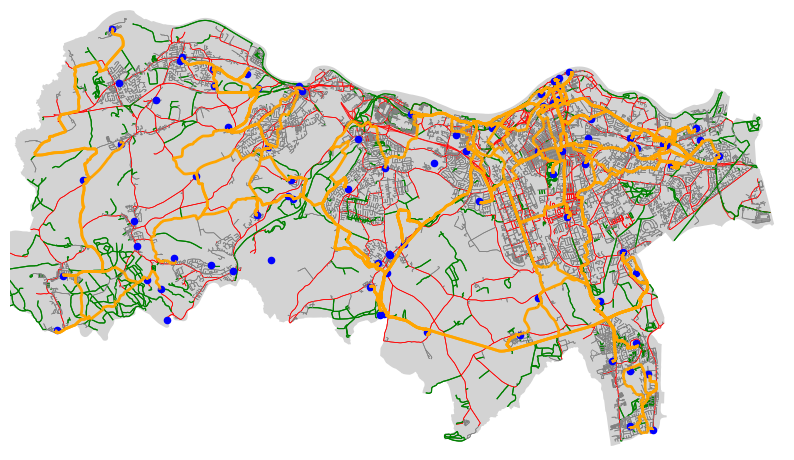

In [68]:
fig, ax = plt.subplots(figsize=(10, 10))
# plot boundary as grey polygon
boundary.plot(ax=ax, color="lightgrey", edgecolor="none")
# overlay bike network: thin black edges, no nodes
fig, ax = ox.plot_graph(
    high_traffic_stress,
    ax=ax,
    node_size=0,
    edge_color="red",
    edge_linewidth=0.5,
    show=False,
    close=False,
)
fix, ax = ox.plot_graph(
    non_routable_network,
    ax=ax,
    node_size=0,
    edge_color="red",
    edge_linewidth=0.5,
    show=False,
    close=False,
)
fig, ax = ox.plot_graph(
    no_traffic_stress,
    ax=ax,
    node_size=0,
    edge_color="green",
    edge_linewidth=0.8,
    show=False,
    close=False,
)
fig, ax = ox.plot_graph(
    moderate_traffic_stress,
    ax=ax,
    node_size=0,
    edge_color="grey",
    edge_linewidth=0.5,
    show=False,
    close=False,
)
routed_edges_gdf.plot(ax=ax, color='orange', linewidth=2)
processed_nodes.plot(ax=ax, color='blue', markersize=20)
ax.set_axis_off()
plt.show()

In [69]:

# Map center
center = [boundary.geometry.centroid.y.mean(), boundary.geometry.centroid.x.mean()]
m = folium.Map(location=center, zoom_start=12, tiles='CartoDB positron')

# Boundary outline 
folium.GeoJson(
    boundary.geometry,
    name='Boundary',
    style_function=lambda x: {'color': 'black', 'weight': 2, 'fill': False}
).add_to(m)

# Convert networkx graphs to GeoDataFrames with full geometry 
very_high_stress_gdf = ox.graph_to_gdfs(non_routable_network, nodes=False)
high_stress_gdf = ox.graph_to_gdfs(high_traffic_stress, nodes=False)
no_stress_gdf   = ox.graph_to_gdfs(no_traffic_stress, nodes=False)
moderate_stress_gdf = ox.graph_to_gdfs(moderate_traffic_stress, nodes=False)

# Helper function to add edges to folium
def add_edges_from_gdf(gdf, color, weight=2):
    for idx, row in gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue
        popup_text = f"Highway: {row.get('highway', 'N/A')}"
        if geom.geom_type == 'LineString':
            folium.PolyLine(
                locations=[(y, x) for x, y in geom.coords],
                color=color,
                weight=weight,
                popup=popup_text
            ).add_to(m)
        elif geom.geom_type == 'MultiLineString':
            for line in geom:
                folium.PolyLine(
                    locations=[(y, x) for x, y in line.coords],
                    color=color,
                    weight=weight,
                    popup=popup_text
                ).add_to(m)
                
# add edges
add_edges_from_gdf(very_high_stress_gdf, 'red', 1.5)
add_edges_from_gdf(high_stress_gdf, 'red', 1.5)
add_edges_from_gdf(no_stress_gdf, 'green', 2)
add_edges_from_gdf(moderate_stress_gdf, 'grey', 1)
add_edges_from_gdf(routed_edges_gdf, 'orange', 3.5)

# Add nodes with popup 
for idx, row in processed_nodes.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=5,
        color='blue',
        fill=True,
        fill_opacity=1,
        popup=f"Waypoint ID: {row['id']}<br>Type: {row['source']}"
    ).add_to(m)

# Add simple legend 
legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 180px; height: 150px; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
<b>Legend</b><br>
<span style="color:red;">&#9632;</span> High traffic stress<br>
<span style="color:grey;">&#9632;</span> Moderate traffic stress<br>
<span style="color:green;">&#9632;</span> Low traffic stress<br>
<span style="color:orange;">&#9632;</span> Routed edges<br>
<span style="color:blue;">&#9679;</span> Nodes (waypoints)<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# save
m.save(r"C:\Users\b8008458\OneDrive - Newcastle University\Other\gateshead_nodes.html")


C:\Users\b8008458\AppData\Local\Temp\ipykernel_24156\2612874497.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [boundary.geometry.centroid.y.mean(), boundary.geometry.centroid.x.mean()]
